# **Previsão de temperatura com Regressão Linear e NN**

Motores elétricos possuem em sua estrutura componentes cuja avaliação da temperatura é fundamental, porém economicamente pouco viável. Mais especificamente as temperaturas do enrolamento, dentes e cabeçote do estator, assim como a temperatura do rotor são difíceis de serem medidas sem utilizar instrumentação específica e com grande custo. Um modelo capaz de estimar essas temperaturas com certo grau de confiabilidade, utilizando dados mais simples de serem medidos, teria grande aplicabilidade para fabricantes de motores elétricos. Neste projeto, serã desenvolvido um modelo para estimar a temperatura de operação de motores de veículos elétricos a partir de um *dataset* contendo dados de operação de motores em diferentes condições de operação e uma rede neural Multi Layer Perceptron (MLP).<br>

O dataset utilizado possui temperaturas e condições de operação de diversos testes com motores elétricos, separados por ID. Os dados de interesse para estimar são: <br>

* Temperatura do enrolamento do estator (stator_winding)
* Temperatura dos dentes do estator (stator_tooth)
* Temperatura do cabeçote do estator (stator_yoke)
* Temperatura do rotor (pm) <br>

Os dados utilizados como entrada para a rede neural são:

* Tensão de operação (u_q, u_d)
* Corrente de operação (i_q, i_d)
* Velocidade do motor (motor_speed)
* Temperatura ambiente (ambient)
* Temperatura resfriador (coolant) <br>

Neste projeto, o foco será dado a prever a **temperatura do rotor (pm)**, que é a menos economicamente viável de se medir através de sensores específicos. A seguir serão mostrados os passos para gerar o modelo.


### **Carregamento do *dataset* utilizado para realizar o treinamento da do modelo**

Inicializamos importando bibliotecas necessárias. Em seguida realizamos o carregamento dos dados e das 5 primeiras linhas para averiguar que o conjunto foi carregado integralmente.

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('measures_v2.csv')
df.head()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
0,-0.450682,18.805172,19.086670,-0.350055,18.293219,0.002866,0.004419,0.000328,24.554214,18.316547,19.850691,0.187101,17
1,-0.325737,18.818571,19.092390,-0.305803,18.294807,0.000257,0.000606,-0.000785,24.538078,18.314955,19.850672,0.245417,17
2,-0.440864,18.828770,19.089380,-0.372503,18.294094,0.002355,0.001290,0.000386,24.544693,18.326307,19.850657,0.176615,17
3,-0.327026,18.835567,19.083031,-0.316199,18.292542,0.006105,0.000026,0.002046,24.554018,18.330833,19.850647,0.238303,17
4,-0.471150,18.857033,19.082525,-0.332272,18.291428,0.003133,-0.064317,0.037184,24.565397,18.326662,19.850639,0.208197,17


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1330816 entries, 0 to 1330815
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   u_q             1330816 non-null  float64
 1   coolant         1330816 non-null  float64
 2   stator_winding  1330816 non-null  float64
 3   u_d             1330816 non-null  float64
 4   stator_tooth    1330816 non-null  float64
 5   motor_speed     1330816 non-null  float64
 6   i_d             1330816 non-null  float64
 7   i_q             1330816 non-null  float64
 8   pm              1330816 non-null  float64
 9   stator_yoke     1330816 non-null  float64
 10  ambient         1330816 non-null  float64
 11  torque          1330816 non-null  float64
 12  profile_id      1330816 non-null  int64  
dtypes: float64(12), int64(1)
memory usage: 132.0 MB


In [4]:
df.describe()

,u_q,coolant,stator_winding,u_d,stator_tooth,motor_speed,i_d,i_q,pm,stator_yoke,ambient,torque,profile_id
count,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06,1.330816e+06
mean,5.427900e+01,3.622999e+01,6.634275e+01,-2.513381e+01,5.687858e+01,2.202081e+03,-6.871681e+01,3.741278e+01,5.850678e+01,4.818796e+01,2.456526e+01,3.110603e+01,4.079306e+01
std,4.417323e+01,2.178615e+01,2.867206e+01,6.309197e+01,2.295223e+01,1.859663e+03,6.493323e+01,9.218188e+01,1.900150e+01,1.999100e+01,1.929522e+00,7.713575e+01,2.504549e+01
min,-2.529093e+01,1.062375e+01,1.858582e+01,-1.315304e+02,1.813398e+01,-2.755491e+02,-2.780036e+02,-2.934268e+02,2.085696e+01,1.807669e+01,8.783478e+00,-2.464667e+02,2.000000e+00
25%,1.206992e+01,1.869814e+01,4.278796e+01,-7.869090e+01,3.841601e+01,3.171107e+02,-1.154061e+02,1.095863e+00,4.315158e+01,3.199033e+01,2.318480e+01,-1.374265e-01,1.700000e+01
50%,4.893818e+01,2.690014e+01,6.511013e+01,-7.429755e+00,5.603635e+01,1.999977e+03,-5.109376e+01,1.577401e+01,6.026629e+01,4.562551e+01,2.479733e+01,1.086035e+01,4.300000e+01
75%,9.003439e+01,4.985749e+01,8.814114e+01,1.470271e+00,7.558668e+01,3.760639e+03,-2.979688e+00,1.006121e+02,7.200837e+01,6.146083e+01,2.621702e+01,9.159718e+01,6.500000e+01
max,1.330370e+02,1.015985e+02,1.413629e+02,1.314698e+02,1.119464e+02,6.000015e+03,5.189670e-02,3.017079e+02,1.136066e+02,1.011480e+02,3.071420e+01,2.610057e+02,8.100000e+01


### **Análise Exploratória**

Iremos iniciar a análise observando como as variáveis de interesse se comporam para diferentes perfis de motores. Podemos observar pelas figuras geradas como as temperaturas comportam-se para diferentes perfis. Nota-se que as temperaturas de cada componente se comportam de maneira semelhante para cada perfil analisado.

Text(0.5, 1.0, 'Perfil 50')

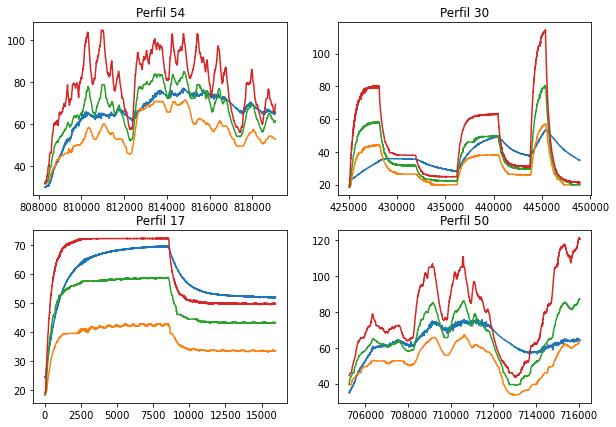

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10,7))

axs[0, 0].plot(df.loc[df['profile_id'] == 54, 'pm'])
axs[0, 0].plot(df.loc[df['profile_id'] == 54, 'stator_yoke'])
axs[0, 0].plot(df.loc[df['profile_id'] == 54, 'stator_tooth'])
axs[0, 0].plot(df.loc[df['profile_id'] == 54, 'stator_winding'])
axs[0, 0].set_title('Perfil 54')

axs[0, 1].plot(df.loc[df['profile_id'] == 30, 'pm'])
axs[0, 1].plot(df.loc[df['profile_id'] == 30, 'stator_yoke'])
axs[0, 1].plot(df.loc[df['profile_id'] == 30, 'stator_tooth'])
axs[0, 1].plot(df.loc[df['profile_id'] == 30, 'stator_winding'])
axs[0, 1].set_title('Perfil 30')

axs[1, 0].plot(df.loc[df['profile_id'] == 17, 'pm'])
axs[1, 0].plot(df.loc[df['profile_id'] == 17, 'stator_yoke'])
axs[1, 0].plot(df.loc[df['profile_id'] == 17, 'stator_tooth'])
axs[1, 0].plot(df.loc[df['profile_id'] == 17, 'stator_winding'])
axs[1, 0].set_title('Perfil 17')

axs[1, 1].plot(df.loc[df['profile_id'] == 50, 'pm'])
axs[1, 1].plot(df.loc[df['profile_id'] == 50, 'stator_yoke'])
axs[1, 1].plot(df.loc[df['profile_id'] == 50, 'stator_tooth'])
axs[1, 1].plot(df.loc[df['profile_id'] == 50, 'stator_winding'])
axs[1, 1].set_title('Perfil 50')

A seguir observa-se a matriz de correlação dos dados utilizados no modelo. Nota-se que existe uma razoável correlação entre a maior parte dos dados de entrada e os dados de saída (pm). Dessa forma, é possível, utilizando a modelagem adequada, realizar a previsão da temperatura do rotor através dos dados das condições de operação. <br>
A seguir será feito o pré-processamento dos dados de entrada do modelo.

<AxesSubplot:>

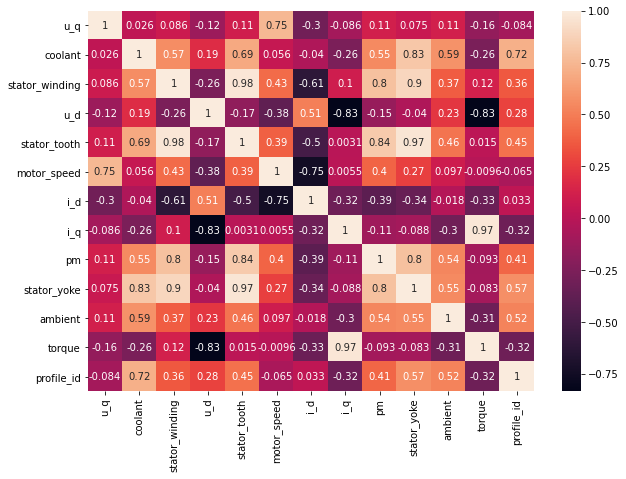

In [6]:
fig, ax = plt.subplots(figsize=(10,7))  
sns.heatmap(df.corr(method='spearman'), annot=True, ax=ax)

### **Pré-processamento dos dados**

Primeiro, realizamos a separação dos dados entre dados de entrada (X) e dados de saída (y). Modelos de *Machine Learning* comumente têm sua capacidade de aprendizado ampliado quando utilizados dados escalonados. Neste caso, faremos a normalização dos dados de entrada (matriz X) para que tenham média igual a zero e desvio padrão unitário. 

In [7]:
from sklearn.preprocessing import StandardScaler

X =  df[['u_q', 'u_d', 'i_q', 'i_d', 'coolant', 'motor_speed', 'ambient']]
y = df['pm']


X_scaled = StandardScaler().fit_transform(X)

### **Separação dos dados de treinamento e teste**

Para treinar modelos de *Machine Learning*, separam-se os dados entre dados para o treinamento e dados para teste. O objetivo dessa separação é que o modelo consiga aprender a prever a temperatura do rotor (pm) através dos dados de treinamento e consiga generalizar esse aprendizado para dados que não estavam presentes no treinamento. Os dados foram separados na proporção 80/20, sendo 80% para treinamento e 20% para teste.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, train_size=0.8, random_state=1)

### **Treinamento do modelo proposto**
Com todo o pré-processamento realizado, podemos treinar o modelo para prever a temperatura do rotor (pm). Para realizar a regressão, foi utilizada uma rede neural Multi Layer Perceptron (MLP), com 3 camadas intermediárias, contendo 400, 300, e 200 neurônios em cada camada, respectivamente. Foi utilizado o algoritmo de Gradiente Descendente Estocástico e a função de ativação ReLu. Também foi empregada a técnica de *early stopping* com um conjunto de validação de 20% para evitar que o modelo apresente *overfitting*, ou vicie com os dados de treinamento. Mais detalhes sobre a parametrização do treinamento podem ser observados na implementação a seguir. <br>
Depois do treinamento, é realizada a previsão para avaliar os resultados obtidos. Como métrica, foi utilizado o coeficiente de determinação (R²) e a Raiz do erro quadrático médio (RMSE, do inglês *Root Mean Square Deviation*).

In [9]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

regr = MLPRegressor(hidden_layer_sizes=(400, 300, 200), activation='relu', solver='sgd', early_stopping=True, 
                    validation_fraction=0.2, learning_rate='adaptive', learning_rate_init=0.001, verbose=False,
                    momentum=0.9, nesterovs_momentum=True, batch_size=50, n_iter_no_change=5, max_iter=500).fit(X_train, y_train)

y_pred_test = regr.predict(X_test)
y_pred_train = regr.predict(X_train)

R2_test = r2_score(y_test, y_pred_test)
R2_train = r2_score(y_train, y_pred_train) 

RMSE_test = mean_squared_error(y_test, y_pred_test, squared=False)
RMSE_train = mean_squared_error(y_train, y_pred_train, squared=False)

print('R² Test:', round(R2_test,2))
print('RMSE Test:', round(RMSE_test,2))

print('R² Train:', round(R2_train,2))
print('RMSE Train:', round(RMSE_train,2))

R² Test: 0.99
RMSE Test: 2.22
R² Train: 0.99
RMSE Train: 2.05


Como resultado, obteve-se um modelo capaz de prever a temperatura do rotor consideravelmente bem. O mesmo foi capaz de prever as temperaturas do rotor apresentando um Coeficiente de determinação R²=0.99 e um erro RMSE=2.22 °C. Tal modelo poderia ser um meio de evitar gastos expressivos com sensoriamento específico para medir a temperatura do rotor de motores elétricos, sendo possível realizar as medições através de dados cuja aquisição é mais simples e de custo menor.<br>

O *dataset* aqui utilizado foi o mesmo da pesquisa: <br>
[Estimating Electric Motor Temperatures with Deep Residual Machine Learning](https://ieeexplore.ieee.org/abstract/document/9296842)
